<a href="https://colab.research.google.com/github/abhi-glitchhg/missionaries_cannibals_AI_assignment/blob/main/AI_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem statement


In the missionaries and cannibals problem, three missionaries and three cannibals must cross a river using a boat which can carry at most two people, under the constraint that, for both banks, if there are missionaries present on the bank, they cannot be outnumbered by cannibals (if they were, the cannibals would eat the missionaries). [source](https://en.wikipedia.org/wiki/Missionaries_and_cannibals_problem)


## Thinking a bit on the problem statement

So we have 3 missionaries (M) and 3 Cannibals (C). One boat and two river banks. We have to make sure that on both banks the number of cannibals is less than or equal to the number of Missionaries. 

There is one special case that if there are no missionaries on a bank, but number of cannibals is more than one, then that state is pretty much valid. 

We can reduce the number of variables by only focusing on the one side of the bank. If we know the number of `M` and `C`s on one side, then it is very much easy to calculate the number on another side. 


Hence, Let's denote a particular state as a tuple of (`m`, `c`). Okay by this data structure we do know what is the number of but we also have to encode the position of the boat, So lets extend the tuple as (`m`,`c`,`boolean which represents if the boat is at the initial bank side`).


Hence our Initial state could be represented as (3,3,`True`)

 
and the goal state can be formed as (0,0,`False`). 


#### Below is a state diagram for the problem. 

The Yellow colored node represents the repeated state, Red node represents the invalid state/state where number of Canniabls is more than the number of Missionaries. The green Node is a goal state.   









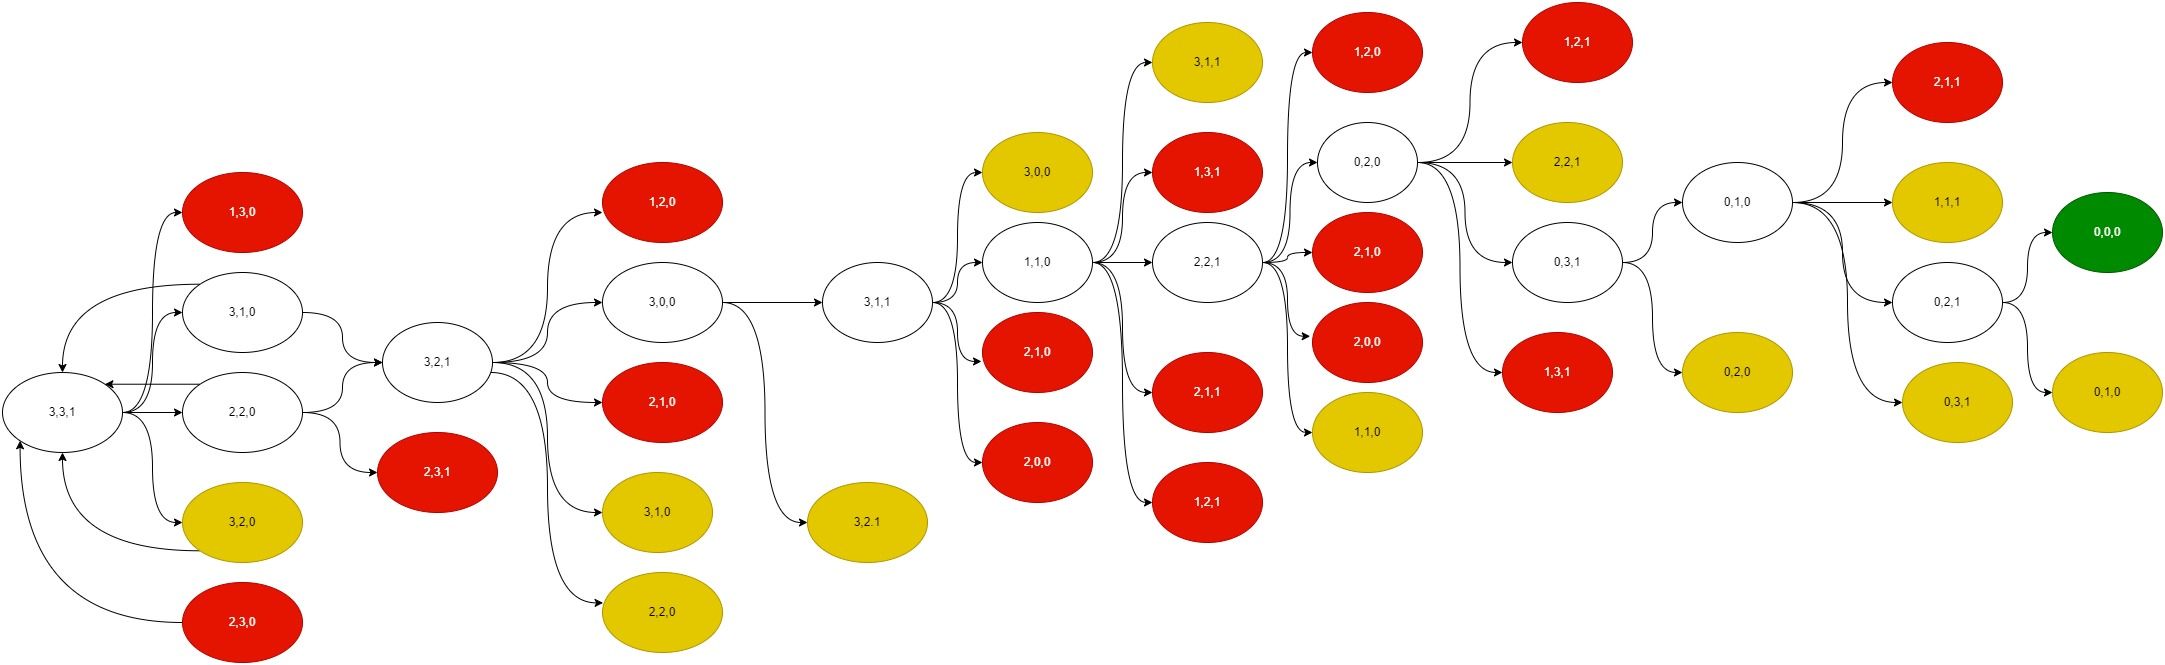

## Imports 

In [1]:
import time 
import sys
from collections import deque

pretty_print = sys.stdout.write

## Constructing the problem 

#### I am going to solve this problem using some classes. Class `Side` represents the original side of the river bank. And class `Node` represents the state in a state diagram. 


This design choice is inspired from the official github [repository](https://github.com/aimacode/aima-python)



In [2]:
# src : https://github.com/aimacode/aima-python/blob/61d695b37c6895902081da1f37baf645b0d2658a/search.py#L15


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1




# src: https://github.com/aimacode/aima-python/blob/61d695b37c6895902081da1f37baf645b0d2658a/search.py#L68
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table 
        return hash(self.state)


#


In [3]:
# This class represents the node problem 

class Side(Problem):
  def __init__(self, cannibals, missionaries, end_state = (0,0,False)):
    """ Constructor"""
    self.cannibals = cannibals
    self.missionaries = missionaries
    self.initial = (self.cannibals, self.missionaries, True)
    self.end_state = end_state
    super().__init__(self.initial, self.end_state)

  def goal_state(self, node):
    """If you reach this state, exploration stops."""
    return node == self.end_state

  def leave(self, state,  action):
    """
    boat leaves the side, This action is performed when the state[2] is true
    returns a new state that would form if we perform `action` on the current `state`
    """
    return tuple((state[0]-action[0], state[1]- action[1], not state[2]))

  def add(self, state, action):
    """
    boat arrives at the side, This action is performed when the state[2] is false
    returns a new state that would form if we perform `action` on the current `state`
    """
    return tuple((state[0]+action[0], state[1]+ action[1], not state[2]))

  def result(self, state, action):
    """ 
    perform the action on the state. action represents the possible combination in the boat. that is it could be (0,0), (0,1), (1,0), (2,0) or (0,2)
    Whether to add or leave the people depends on the state. ie if state[2] is true, we perform the leaving and if state[2] false, we add. 

    """
    if (state[2]):
      return self.leave(state, action)
    else: 
      return self.add(state, action)
    
  
  def isvalid(self, state):
    """checks if the state is valid or not."""
    if state[0]<state[1] and state[0]!=0:
      return False
    if state[0]> self.initial[0] or state[1]>self.initial[1]:
      return False
    if state[0]<0 or state[1]<0:
      return False
    
    if (self.initial[1]- state[1])> (self.initial[0]-state[0]) and (self.initial[0]-state[0]!=0):
      return False 
    return True

  def actions(self, state):
    """ All possible actions that are possible at given state"""
    actions_list = []
    if (self.isvalid(self.result(state,(1,0)))):
      actions_list.append((1,0))
    if (self.isvalid(self.result(state,(2,0)))):
      actions_list.append((2,0))
    if (self.isvalid(self.result(state,(1,1)))):
      actions_list.append((1,1))
    if (self.isvalid(self.result(state,(0,2)))):
      actions_list.append((0,2))
    if (self.isvalid(self.result(state,(0,1)))):
      actions_list.append((0,1))
    return actions_list


## Search Algorithms

#### Now that we have  a way to represent the state and the problem, we will proceed on implementing the different search algorithms for the graph structure. 


> Is it a good idea to check for the repeated states? 

Yesss! We must check for the repeated states, as we can see the amount of repeated states is significant and it is very likely that we would be forever stuck in the loop if we dont check for repeated states. If we find repeated state we should proceed with that state. 

In [4]:

def depth_first_graph_search(problem):
    frontier = [(Node(problem.initial))]  
    returned_nodes = []
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node 
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier)
    return None


def breadth_first_graph_search(problem):
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child
                frontier.append(child)
    return None



## now that we have implemented the search algorithm, lets find out the solution




In [5]:
path = depth_first_graph_search(Side(3,3)).solution()
print(path)

[(0, 2), (0, 1), (0, 2), (0, 1), (2, 0), (1, 1), (2, 0), (0, 1), (0, 2), (0, 1), (0, 2)]


What does this `path` represents?

> the first tuple in the path list is (0,2) that represents that we are starting from the side of the bank and the boat is filled with 0M and 2Cs. similary second typle represents the returning boat. (0,1) represents 0M and 1C in the boat. 

But this is difficult to visualize, hence I have written a simulation script to see the transitions. Hope it helps! 



## some utilities to visualize the solution

In [6]:
def perf(side, action, sign):
  return list((side[0]+sign*action[0], side[1]+sign*action[1]) )
  

def print_stable_state(side_a, side_b, with_state=True):
  if with_state: stable_string = f"\r{'M'*side_b[0]} {'C'*side_b[1]} \t\t\t  {'M'*side_a[0]} {'C'*side_a[1]} \n{side_b}\t\t\t{side_a}"
  else: stable_string = f"\r{'M'*side_b[0]} {'C'*side_b[1]} \t\t\t  {'M'*side_a[0]} {'C'*side_a[1]}" 
  pretty_print(stable_string)
def print_unstable_state2(side_a, side_b, path):
  unstable_string = f"\r{'M'*side_b[0]} {'C'*side_b[1]} \t\t {'M'*path[0]}{'C'*path[1]} \t  {'M'*side_a[0]} {'C'*side_a[1]}  \t {path}" 
  pretty_print(unstable_string)
def print_unstable_state1(side_a, side_b, path):
  unstable_string = f"\r{'M'*side_b[0]} {'C'*side_b[1]} \t {'M'*path[0]}{'C'*path[1]} \t\t  {'M'*side_a[0]} {'C'*side_a[1]}  \t {path}" 
  pretty_print(unstable_string)

def update_sides(side_a, side_b, up1, up2, t=1, with_state=True):
  side_b = perf(side_b, up1, -1)
  print_unstable_state1(side_a, side_b, up1)
  time.sleep(t)
  print_unstable_state2(side_a, side_b,up1)
  time.sleep(t)
  side_a = perf(side_a, up1, +1)
  print_stable_state(side_a, side_b, with_state=with_state)
  time.sleep(t*2)
  side_a = perf(side_a, up2, -1)
  print_unstable_state2(side_a, side_b, up2)
  time.sleep(t)
  print_unstable_state1(side_a, side_b, up2)
  time.sleep(t)
  side_b = perf(side_b, up2, +1)
  print_stable_state(side_a, side_b, with_state=with_state)
  time.sleep(t*2)
  return side_a, side_b
  


def simulate(path, t=1, with_state=True):
  first_stuff = path[0]
  path = path[1:]

  side_a = [3,3]
  side_b = [0,0]

  print_stable_state(side_a, side_b, with_state)
  time.sleep(t)
  side_a = perf(side_a, first_stuff, -1)
  print_unstable_state2(side_a, side_b, first_stuff)
  time.sleep(t)
  print_unstable_state1(side_a, side_b, first_stuff)
  time.sleep(t)
  side_b = perf(side_b, first_stuff, +1   )
  print_stable_state(side_a, side_b, with_state)
  time.sleep(t)

  for i,j in zip(path[::2], path[1::2]):
    side_a, side_b = update_sides(side_a, side_b, i, j,t,with_state)


### Some descr about what simulate function is doing; 


We have two sides, `side_b` and `side_a`, initially `side_b` is empty and `side_a` has 3M and 3Cs. 

Boat starts from `side_a`, and we also see the tuple besiede `side_a` which represents the current state of the boat from the `path`.

Whenever boat reaches the other side,  the updated state of the both sides is printed below them. 
If we allow printing the states we can see all the previous stable states that out problem has seen. If you dont want to see the states and just enjoy (:P) the animation, then use `with_state=False` argument in the simulate function. 

For faster animation, reduce the sleeping time `t`.

I am attaching the state diagram here for better understanding and tracing purposes. 





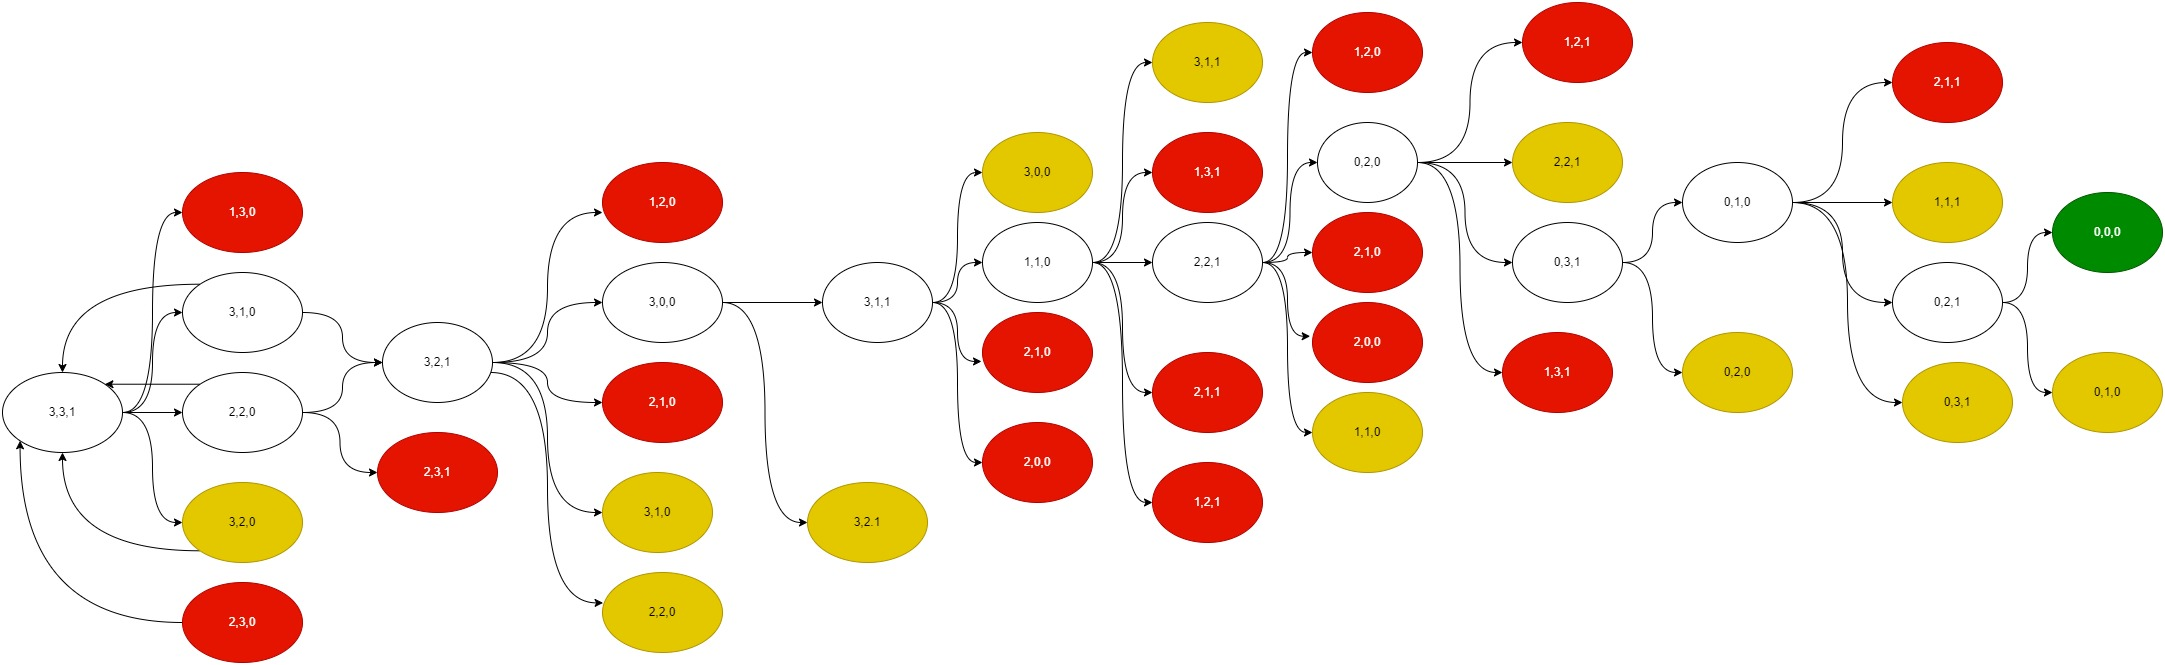

In [8]:
simulate(path, t=2, with_state=False)

MMM CCC 			   

In [10]:
path = depth_first_graph_search(Side(3,3)).solution()
simulate(path, t=0.1)

  			  MMM CCC 
 CC 			  MMM C 
 C 			  MMM CC 
 CCC 			  MMM  
 CC 			  MMM C 
MM CC 			  M C 
M C 			  MM CC 
MMM C 			   CC 
MMM  			   CCC 
MMM CC 			   C 
MMM C 			   CC 
MMM CCC 			    
[3, 3]			[0, 0]

# Why do you think people have a hard time solving this puzzle, given that the state space is so simple?



> As we see from the state diagram, path to the green node from starting node is very straightforward. But in general people dont much think of the future states and possible bad choices they would make. Out of 41 nodes in state space,  16 nodes result in death of Missionaries, 13 nodes are repeated nodes(basically time travel!). Hence these nodes don't contribute in the optimal solution. 

> It is very highly that one might get stuck in loop. 